### Install dependencies

In [1]:
! pip install --quiet transformers torchvision bitsandbytes datasets evaluate peft trl scikit-learn Pillow ipywidgets jupyterlab_widgets tensorboard sentencepiece

## Load model from Hugging Face Hub

In [1]:
import os
from huggingface_hub import login

# login("")

In [2]:
import torch
from transformers import AutoProcessor, AutoModel
import torch.nn as nn
from transformers import SiglipModel

model_id = "google/medsiglip-448"

class SiglipForClassification(nn.Module):
    def __init__(self, siglip_model, num_classes=1):  # num_classes=1 for binary classification
        super().__init__()
        self.siglip = siglip_model
        self.classifier = nn.Linear(siglip_model.config.vision_config.hidden_size, num_classes)
        self.loss_fn = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
        
    def forward(self, pixel_values, labels=None, **kwargs):
        # Get vision embeddings
        vision_outputs = self.siglip.vision_model(pixel_values=pixel_values)
        pooled_output = vision_outputs.pooler_output
        
        # Get logits (single output for binary classification)
        logits = self.classifier(pooled_output)  # Shape: [batch_size, 1]
        
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            # Ensure labels are float and have shape [batch_size, 1]
            labels = labels.view(-1, 1).float()  # Reshape and convert to float
            loss = self.loss_fn(logits, labels)
        
        return {
            "loss": loss,
            "logits": logits
        }

# Load base SigLIP model
base_model = SiglipModel.from_pretrained(model_id)
model = SiglipForClassification(base_model, num_classes=1)  # Binary classification
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

## Prepare fine-tuning dataset


Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [3]:
from datasets import load_dataset, Image


# 1. Download and Unzip the data from Hub

from huggingface_hub import hf_hub_download
import zipfile
import os

# === DOWNLOAD ZIP FILE FROM HUGGING FACE DATASET REPO ===
repo_id = "IraBid-Medical-AI/Appendicitis_vs_normal_calssification"
filename = "Appendicitis_vs_normal.zip"

# Download the ZIP to local cache
zip_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=filename,
    revision="main"
)

# === UNZIP TO TARGET FOLDER ===
extract_dir = "Appendicitis_vs_normal"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Done: Extracted to {extract_dir}")


# 2. Load dataset
from datasets import load_dataset, DatasetDict

# Path to extracted dataset folder
data_dir = r"./Appendicitis_vs_normal/Appendicitis_vs_normal"  # UPDATE this path

# Define paths for each split
train_dir = f"{data_dir}/Training_data_png"
val_dir   = f"{data_dir}/Validation_data_png"
test_dir  = f"{data_dir}/Test_data_png"

# Load splits using 'imagefolder' format
train_ds = load_dataset("imagefolder", data_dir=train_dir, split="train")
val_ds   = load_dataset("imagefolder", data_dir=val_dir, split="train")
test_ds  = load_dataset("imagefolder", data_dir=test_dir, split="train")

# Combine into a DatasetDict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(data)

# 3. Peek at a sample
data["train"][0]["image"]
# Display the corresponding label
print(data["train"][0]["label"])


✅ Done: Extracted to Appendicitis_vs_normal


Resolving data files:   0%|          | 0/435 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/109 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/137 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 137
    })
})
0


Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

In [7]:
# adding 'path' column to each dataset

def add_path(example, root_dir):
    # The 'image' field is a PIL Image, but the dataset from 'imagefolder' also
    # includes the 'image' feature with 'path' attribute for each image.
    # However, if not present, reconstruct the path from root_dir and label info.
    
    # Huggingface's imagefolder loader often provides 'path' in 'image' feature metadata,
    # So we can try to get it directly:
    try:
        image_path = example["image"].filename
    except AttributeError:
        # fallback: try reconstructing (if you know directory structure and filenames)
        image_path = None

    # If for some reason filename is missing, you can create path from label + file name if available,
    # but usually filename should be in the 'image' object.
    
    return {"path": image_path}

# Add path column using map for all datasets:
train_ds = train_ds.map(lambda x: add_path(x, train_dir))
val_ds = val_ds.map(lambda x: add_path(x, val_dir))
test_ds = test_ds.map(lambda x: add_path(x, test_dir))

# Update the dataset dict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})


Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

In [8]:
print(data["train"].features)


{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['negative', 'positive']), 'path': Value('string')}


In [ ]:
data["train"][287]["path"]

'D:\\_IramS\\_Iram_MKK\\Projects_code\\Project_MKK\\AAPM\\MedGemma\\Appendicitis_vs_normal\\Appendicitis_vs_normal\\Training_data_png\\positive\\5002_5002_slice_055.png'

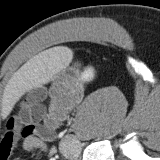

In [10]:
data["train"][287]["image"]

In [11]:
data["train"][287]["label"]

1

## Fine-tune the model

Contrastive image-text learning is a method that trains models to learn the relationship between images and text, such that the representations of matching image-text pairs are brought closer together in a shared embedding space while non-matching pairs are pushed further apart.

This notebook demonstrates contrastive fine-tuning of MedSigLIP, where the vision and text encoders are jointly trained on image and text data, using the `Trainer` from the Hugging Face `Transformers` library.

Define a data collator to prepare batches of training examples.

In [ ]:
def collate_fn(examples):
    images = [example["image"] for example in examples]
    labels = [example["label"] for example in examples]
    paths = [example["path"] for example in examples]  # add paths here
    
     # Process images
    batch = processor(images=images, return_tensors="pt")
    
    # add labels and paths to the batch
    batch["labels"] = torch.tensor(labels, dtype=torch.float).view(-1, 1)
    batch["path"] = paths  # return paths as is (list of strings)
    
    return batch


In [ ]:
#import torch


#def collate_fn(examples):
    # Extract images and labels
#    images = [example["image"] for example in examples]
#    labels = [example["label"] for example in examples]
    
    # Process images
#    batch = processor(images=images, return_tensors="pt")
    
    # Add labels
#    batch["labels"] = torch.tensor(labels, dtype=torch.float).view(-1, 1)
    
#    return batch

Configure training parameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [47]:
from transformers import TrainingArguments

num_train_epochs = 2  # @param {type: "number"}
learning_rate = 1e-5  # @param {type: "number"}

training_args = TrainingArguments(
    output_dir="medsiglip-appendicitis-binary",  # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,      # Number of training epochs
    per_device_train_batch_size=8,          # Batch size per device during training
    per_device_eval_batch_size=8,           # Batch size per device during evaluation
    gradient_accumulation_steps=4,          # Number of steps before performing a backward/update pass
    logging_steps=10,                       # Number of steps between logs
    save_strategy="epoch",                  # Save checkpoint every epoch
    eval_strategy="steps",                  # Evaluate every `eval_steps`
    eval_steps=0.2,                          # Number of steps between evaluations
    learning_rate=learning_rate,            # Learning rate
    weight_decay=0.01,                      # Weight decay to apply
    warmup_steps=1,                         # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine", 
    remove_unused_columns=False,            # Use cosine learning rate scheduler
    push_to_hub=True,                       # Push model to Hub
    report_to="tensorboard",                # Report metrics to tensorboard
)

In [48]:
import evaluate
import numpy as np

# Load the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
roc_auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    """
    Compute metrics for binary classification (normal vs. positive).
    """
    predictions, labels = eval_pred  # predictions: [batch_size, 1], labels: [batch_size]
    
    # Convert logits to probabilities and predictions
    probabilities = 1 / (1 + np.exp(-predictions))  # Sigmoid: [batch_size, 1]
    pred_classes = (probabilities > 0.5).astype(np.int32).flatten()  # Threshold at 0.5: [batch_size]
    
    # Ensure labels are integers
    labels = labels.astype(np.int32)
    
    # Compute metrics
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=pred_classes,
        references=labels,
    ))
    metrics.update(f1_metric.compute(
        predictions=pred_classes,
        references=labels,
        average ="macro"
    ))
    # Compute ROC-AUC using positive class probabilities
    try:
        auc = roc_auc_metric.compute(
            prediction_scores=probabilities.flatten(),  # Positive class probabilities
            references=labels,
            average="macro"  # Binary classification uses macro for consistency
        )
        metrics.update({"auc": auc["roc_auc"]})
    except Exception as e:
        metrics.update({"auc": None, "auc_error": str(e)})
    
    return metrics

Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters and data collator.

In [49]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(50)),  # Use subset of validation set for faster run
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

Launch the fine-tuning process.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Auc
6,No log,0.795991,0.580000,0.440000,0.636364
12,1.701100,0.696976,0.700000,0.678250,0.672078
18,1.701100,0.685540,0.720000,0.696181,0.683442
24,1.547900,0.731713,0.660000,0.615559,0.693182


## Evaluate the fine-tuned model on a classification task

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report, 
    confusion_matrix
)
from tqdm import tqdm

def evaluate_model(model, test_dataset, processor, batch_size=32, device='cuda'):
    """
    Comprehensive evaluation of the fine-tuned model on test data
    """
    model.eval()
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    all_predictions = []
    all_labels = []
    all_logits = []
    all_paths = []
    print("Evaluating model on test dataset...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            if 'pixel_values' not in batch or 'labels' not in batch:
                raise ValueError("Batch missing required keys: 'pixel_values' or 'labels'.")
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            paths = batch['path']
            outputs = model(pixel_values=pixel_values)
            logits = outputs['logits']
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.4).long().view(-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(probabilities.cpu().numpy().flatten())  # Save probabilities
            all_paths.extend(paths)
    return np.array(all_predictions), np.array(all_labels), np.array(all_logits), all_paths


def compute_detailed_metrics(predictions, labels, class_names):
    """
    Compute detailed evaluation metrics
    """
    
    # Basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Weighted averages
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print()
    
    # Per-class metrics
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    
    print("-" * 70)
    print(f"{'Weighted Avg':<15} {precision_weighted:<12.4f} {recall_weighted:<12.4f} {f1_weighted:<12.4f} {sum(support):<10}")
    print(f"{'Macro Avg':<15} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f} {sum(support):<10}")
    
    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }


def run_evaluation():
    ABDOMINAL_PAIN_CLASSES = ['normal', 'appendicitis']
    test_data = data["test"]
    print(f"Test dataset size: {len(test_data)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions, labels, probabilities, paths = evaluate_model(
        model, 
        test_data, 
        processor, 
        batch_size=32, 
        device=device
    )
    metrics = compute_detailed_metrics(predictions, labels, ABDOMINAL_PAIN_CLASSES)
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(
        labels, 
        predictions, 
        target_names=ABDOMINAL_PAIN_CLASSES,
        digits=4
    ))
    # Save results to Excel
    df_results = pd.DataFrame({
        "image_path": paths,
        "probability": probabilities,
        "actual_label": labels.flatten(),
        "prediction": predictions.flatten()
    })
    df_results.to_excel("test_predictions.xlsx", index=False)
    print("✅ Results saved to test_predictions.xlsx")
    return metrics, predictions, labels, probabilities, paths

# Run the evaluation
evaluation_results = run_evaluation()

Test dataset size: 137
Evaluating model on test dataset...


Testing: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]

EVALUATION RESULTS
Overall Accuracy: 0.6496
Weighted F1-Score: 0.5887
Macro F1-Score: 0.5107

Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
normal          0.6694       0.9101       0.7714       89        
appendicitis    0.5000       0.1667       0.2500       48        
----------------------------------------------------------------------
Weighted Avg    0.6101       0.6496       0.5887       137       
Macro Avg       0.5847       0.5384       0.5107       137       

Detailed Classification Report:
              precision    recall  f1-score   support

      normal     0.6694    0.9101    0.7714        89
appendicitis     0.5000    0.1667    0.2500        48

    accuracy                         0.6496       137
   macro avg     0.5847    0.5384    0.5107       137
weighted avg     0.6101    0.6496    0.